## Trabajo Spark

https://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1)

Los datos que usamos son los de verano 2017 e invierno 2017-2018, y luego los de principios del 2020.

In [43]:
import matplotlib.pyplot as plt
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
import json

VALORES = ['user_day_code','user_type','ageRange','idplug_station',
         'idunplug_station','unplug_hourTime','travel_time']

def adaptar(dicc):
        """
        Desempaqueta las fechas en forma unplug_hourTime: {$date: string}.
        """
    
        if isinstance(dicc['unplug_hourTime'], dict):
            dicc['unplug_hourTime'] = dicc['unplug_hourTime']['$date']
            
        return dicc


def leer(lista):
    """
    Recibe una lista de archivos json, se queda con los datos relevantes, y ajusta el formato de las fechas.
    Devuelve un unico rdd con todos los datos.
    """
    
    if not isinstance(lista, list):
        lista = [lista]
        
    sc = SparkContext.getOrCreate()
    aux = lambda x: {a:x[a] for a in VALORES}
    
    total = sc.textFile(lista[0]).map(json.loads).map(aux)
    
    for archivo in lista[1:]:
        dat = sc.textFile(archivo).map(json.loads).map(aux)
        total = total.union(dat)
    
    return total.map(adaptar)

In [8]:
import re
import datetime
PATTERN = re.compile(r'[+][0-9]+$')

def tiempo(content):
    """
    Una funcion para transformar string a objeto datetime.
    Las fechas tienen dos formatos distintos y se tratan de la misma forma
    con una expresion regular.
    """
    
    match = PATTERN.search(content)
    if match:
        formato = '%Y-%m-%dT%H:%M:%S.%f%z'  
    else:
        formato = '%Y-%m-%dT%H:%M:%SZ'
        
    return datetime.datetime.strptime(content, formato)

In [44]:
a = leer('202001_movements.json').sample(False, 0.2)
a. take(10)

[{'user_day_code': 'f77e4af707dfc3753aea3a3964923f256ef9c0be1413998c1f084b6c8ae82a2f',
  'user_type': 1,
  'ageRange': 4,
  'idplug_station': 82,
  'idunplug_station': 129,
  'unplug_hourTime': '2020-01-01T00:00:00Z',
  'travel_time': 473},
 {'user_day_code': 'd83c9c0652b085671a7201039d35b1e816805fafad69ea5f1da08f338189d6ec',
  'user_type': 1,
  'ageRange': 5,
  'idplug_station': 128,
  'idunplug_station': 54,
  'unplug_hourTime': '2020-01-01T00:00:00Z',
  'travel_time': 234},
 {'user_day_code': '6ef1d4cd006e85dbfc3696bda068575bcd8c6c09e93d7b1fd74cc4e67153dd42',
  'user_type': 1,
  'ageRange': 0,
  'idplug_station': 194,
  'idunplug_station': 171,
  'unplug_hourTime': '2020-01-01T00:00:00Z',
  'travel_time': 182},
 {'user_day_code': 'd4cd100c73bf667702a90a14b41faa6023af146e3299fc9a1aa30206c5ef5cae',
  'user_type': 1,
  'ageRange': 5,
  'idplug_station': 127,
  'idunplug_station': 84,
  'unplug_hourTime': '2020-01-01T00:00:00Z',
  'travel_time': 287},
 {'user_day_code': '0aeb48aed145316

In [45]:
# Usuarios que mas viajes han realizado en un dia.
# Se usa el codigo de usuario como clave, se agrupa por clave y se ordena el rdd por el
# numero de viajes que ha realizado cada usuario.
a = leer('202001_movements.json')
rdd = a.map(lambda x: (x['user_day_code'],x)).groupByKey().mapValues(list)
numero = rdd.mapValues(len).sortBy(keyfunc=lambda x: x[1],ascending=False)
numero.take(5)

[('034bf7065e3ef64c4d4455c45fb435e1495eec6a143a6ef7d99829164c555b94', 131),
 ('11770e48c981871a3a8bcabaa08ae499449a6eb6178cb6beb72b4713b3d781c1', 124),
 ('85b2d84388d0d4a2bc54321b58024321da67a5d217a6e36b9310a04f7b7f7ac9', 120),
 ('eb1481e316063b5fa0034918025b8753575d6b71f388ca2fc506874c42789097', 118),
 ('ce6e9d365f5cedc35f8774e2ca40546a6b3bf7c5fb07c68eaaa7a2e7e04f8385', 106)]

In [43]:
# Usuarios cuyo ultimo viaje acaba en la misma estacion donde empezo.
# Estacion salida: [0]["idunplug_station"], estacion llegada [-1]["idplug_station"].
rdd = a.map(lambda x: (x['user_day_code'],x)).groupByKey().mapValues(list)
ida = rdd.filter(lambda x: x[1][0]['idunplug_station']==x[1][-1]['idplug_station'])
100*ida.count()/rdd.count()


21.729120713050076

In [8]:
# Los viajes se enlazan, forman "camino". Se considera que cada viaje sucesivo empieza
# en la estacion donde acabo el viaje previo.
def condicion(lista):
    
    b = True
    j = 1
    while j < len(lista):
        b = b and lista[j-1]['idunplug_station'] == lista[j]['idplug_station']
        j += 1
    return b    
    
temp = rdd.filter(lambda x: len(x[1])>2).filter(lambda x: condicion(x[1]))
temp.take(5)


[('f2ad1dfca20ac91815abe9d1219eb3fb2cd87e087c408caedfcb542ff2018a7c',
  [{'user_day_code': 'f2ad1dfca20ac91815abe9d1219eb3fb2cd87e087c408caedfcb542ff2018a7c',
    'user_type': 1,
    'ageRange': 0,
    'idplug_station': 176,
    'idunplug_station': 192,
    'unplug_hourTime': '2020-01-01T00:00:00Z',
    'travel_time': 863},
   {'user_day_code': 'f2ad1dfca20ac91815abe9d1219eb3fb2cd87e087c408caedfcb542ff2018a7c',
    'user_type': 1,
    'ageRange': 0,
    'idplug_station': 192,
    'idunplug_station': 176,
    'unplug_hourTime': '2020-01-01T13:00:00Z',
    'travel_time': 917},
   {'user_day_code': 'f2ad1dfca20ac91815abe9d1219eb3fb2cd87e087c408caedfcb542ff2018a7c',
    'user_type': 1,
    'ageRange': 0,
    'idplug_station': 176,
    'idunplug_station': 192,
    'unplug_hourTime': '2020-01-01T16:00:00Z',
    'travel_time': 779}]),
 ('0e8c93d0f3979d8e1ebe921ff21a4c3224f810a619a63a218664e3c38f4d1b89',
  [{'user_day_code': '0e8c93d0f3979d8e1ebe921ff21a4c3224f810a619a63a218664e3c38f4d1b89',
 

In [9]:
# Por tipo de usuario.
rdd = a.map(lambda x: (x['user_type'],x)).groupByKey().mapValues(len)
rdd.collect()

[(3, 22693), (1, 249537), (2, 645)]

In [49]:
# Filtrado por duracion del viaje, se consideran los viajes de al menos 2 minutos.
rdd = a.map(lambda x: x['travel_time'])
print('Conteo:',rdd.filter(lambda x: x>120).count())
print('Media:',rdd.filter(lambda x: x>120).mean())


Conteo: 266833
Media: 1146.9137587929517


In [36]:
# Estaciones con mayor afluencia (origen + destino).
rdd = a.flatMap(lambda x: [x['idunplug_station'],x['idplug_station']])
b=rdd.countByValue()#.sortBy(keyfunc=id,ascending=False)
dict(sorted(b.items(), key=lambda item: item[1],reverse=True))

{175: 7481,
 43: 7422,
 57: 6132,
 83: 6125,
 163: 5747,
 49: 5329,
 90: 5268,
 168: 4936,
 13: 4693,
 45: 4689,
 41: 4688,
 169: 4666,
 9: 4601,
 149: 4587,
 58: 4536,
 129: 4534,
 157: 4431,
 208: 4380,
 135: 4367,
 19: 4317,
 79: 4256,
 132: 4226,
 161: 4196,
 6: 4170,
 59: 4114,
 64: 4040,
 164: 3998,
 162: 3946,
 84: 3941,
 53: 3927,
 38: 3920,
 42: 3911,
 78: 3902,
 108: 3892,
 95: 3831,
 160: 3756,
 75: 3703,
 145: 3695,
 52: 3666,
 56: 3590,
 189: 3506,
 26: 3494,
 30: 3469,
 62: 3463,
 46: 3446,
 128: 3443,
 74: 3440,
 91: 3353,
 48: 3337,
 113: 3290,
 31: 3273,
 131: 3233,
 65: 3226,
 103: 3220,
 77: 3194,
 17: 3173,
 187: 3150,
 14: 3093,
 133: 3062,
 204: 3052,
 170: 3043,
 76: 3042,
 50: 2995,
 183: 2961,
 55: 2924,
 126: 2922,
 82: 2899,
 81: 2869,
 115: 2866,
 37: 2840,
 33: 2822,
 213: 2821,
 80: 2761,
 181: 2757,
 21: 2707,
 154: 2704,
 130: 2702,
 136: 2690,
 139: 2680,
 73: 2680,
 99: 2673,
 71: 2630,
 8: 2614,
 177: 2613,
 118: 2601,
 172: 2591,
 3: 2586,
 134: 2584

In [38]:
# Estaciones por numero de llegadas.
rdd = a.map(lambda x: x['idplug_station'])
b=rdd.countByValue()#.sortBy(keyfunc=id,ascending=False)
dict(sorted(b.items(), key=lambda item: item[1],reverse=True))

{43: 3748,
 175: 3741,
 83: 3068,
 57: 3057,
 163: 2890,
 49: 2671,
 90: 2638,
 168: 2492,
 13: 2362,
 45: 2360,
 169: 2357,
 41: 2325,
 149: 2302,
 9: 2286,
 129: 2269,
 58: 2267,
 157: 2228,
 135: 2211,
 208: 2195,
 19: 2161,
 132: 2143,
 79: 2139,
 161: 2117,
 6: 2108,
 59: 2059,
 64: 2047,
 164: 1996,
 84: 1985,
 53: 1975,
 38: 1964,
 78: 1961,
 42: 1954,
 162: 1949,
 108: 1945,
 95: 1919,
 160: 1875,
 52: 1846,
 145: 1844,
 75: 1834,
 56: 1796,
 189: 1753,
 26: 1743,
 46: 1742,
 62: 1737,
 30: 1733,
 128: 1723,
 74: 1715,
 48: 1680,
 113: 1658,
 91: 1642,
 31: 1637,
 131: 1625,
 65: 1619,
 103: 1608,
 17: 1598,
 187: 1579,
 77: 1568,
 14: 1560,
 76: 1527,
 133: 1527,
 204: 1527,
 170: 1512,
 50: 1495,
 183: 1480,
 55: 1473,
 82: 1464,
 126: 1449,
 81: 1443,
 115: 1429,
 33: 1429,
 37: 1427,
 213: 1410,
 181: 1385,
 80: 1377,
 21: 1352,
 130: 1349,
 73: 1345,
 99: 1330,
 154: 1327,
 139: 1327,
 136: 1325,
 71: 1322,
 118: 1311,
 8: 1305,
 3: 1305,
 177: 1304,
 134: 1292,
 172: 1281

In [21]:
# Comparacion entre el uso en verano de 2017 e invierno (2017-2018). La conclusión es que
# en verano hay muchos usuarios de vacaciones, y hace demasiado calor como para usar la bicicleta.
datos=leer(['201706_Usage_Bicimad.json','201707_Usage_Bicimad.json','201708_Usage_Bicimad.json','201709_Usage_Bicimad.json','201711_Usage_Bicimad.json','201712_Usage_Bicimad.json','201801_Usage_Bicimad.json','201802_Usage_Bicimad.json'])
datos=datos.map(lambda x: tiempo(x['unplug_hourTime']))
datos_verano = datos.filter(lambda x: 9>=x.month>=6)
datos_invierno = datos.filter(lambda x: 11>=x.month or x.month<=2)
a=datos_verano.count()
b=datos_invierno.count()
print(a,b,a/b)

1444953 2286091 0.6320627656554354


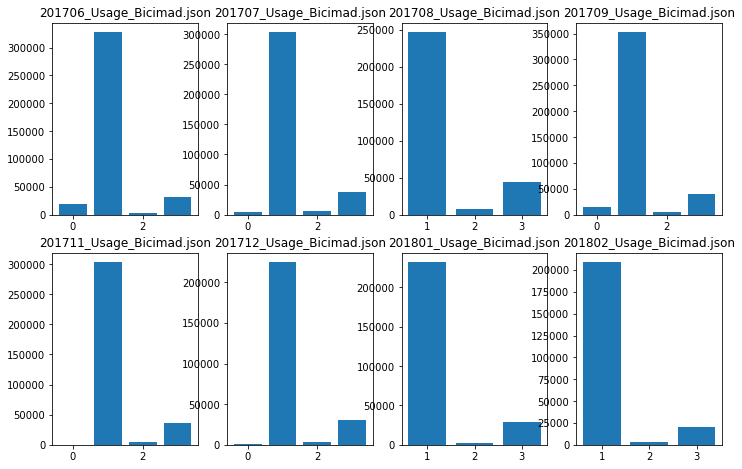

In [37]:
# Graficos que muestran el uso por tipo de usuario y mes.
l_rdd=['201706_Usage_Bicimad.json','201707_Usage_Bicimad.json','201708_Usage_Bicimad.json','201709_Usage_Bicimad.json','201711_Usage_Bicimad.json','201712_Usage_Bicimad.json','201801_Usage_Bicimad.json','201802_Usage_Bicimad.json']
plt.rcParams["figure.figsize"] = (12,12)
fig = plt.figure()
j = 1
for t in l_rdd:
    datos = leer(t).map(lambda x: x['user_type']).countByValue()
    st = f'axfig_{j}'
    st = fig.add_subplot(3,4,j)
    st.title.set_text(t)
    plt.bar(datos.keys(),datos.values())
    j += 1

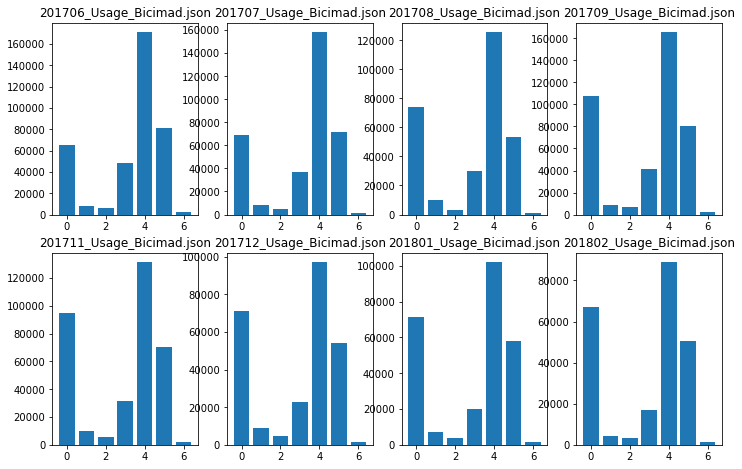

In [38]:
# Graficos que muestran el uso por franja de edad y mes.
plt.rcParams["figure.figsize"] = (12,12)
fig = plt.figure()
j = 1
for t in l_rdd:
    datos = leer(t).map(lambda x: x['ageRange']).countByValue()
    st = f'axfig_{j}'
    st = fig.add_subplot(3,4,j)
    st.title.set_text(t)
    plt.bar(datos.keys(),datos.values())  
    j += 1